# Toy example using SVI 
In this notebook all model paremeters, i.e:  noise variance, lengthscale and variance of activation, all frequencies, variances and lenghscale of component, and variational distributions are learned simultaneously by maximazing the marginal likelihood.

In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal
from gpitch import myplots
import time 
np.random.seed(21)
plt.rcParams['figure.figsize'] = (16, 4)  # set plot size

## Generate synthetic data

In [2]:
# define hyperparameters for data generation
Nc = 10  # number of "harmoncics"
f0 = 220.0 # ideal natural frequency
N, fs = 1000, 16e3  # number of data points and sampling frequency
noise_var = 1e-3  # variance noise
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)  # time vector

Define kernels for component and activation

In [3]:
kern2 = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.01, variance=10.)  # activation kernel

var = 0.25*np.random.rand(Nc)  # variances
var_scale = 1./ (4.*np.sum(var)) #rescale (sigma)
var *= var_scale  
leng = 0.09  # lengthscale
freq = f0*np.asarray(range(1, Nc+ 1)) + np.sqrt(100.)*np.random.randn(1)  # harmonic freqs with random deviation

kern1 = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=leng, variances=var, 
                                     frequencies=freq, Nc=Nc) # component kernel

List of parameters of the kernels we used to generate the data.

In [4]:
#kern1  # kernel used for sample component

In [5]:
#kern2  # kernel used for sample activation

Compute covariance matrices, and sample one component and activation function

In [6]:
Kcom = kern1.compute_K_symm(x)  # cov matrices
Kact = kern2.compute_K_symm(x)
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)  # sample component
com /= np.max(np.abs(com))
com -= com.mean()
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)  # sample activation
act = logistic(g)
act /= np.max(act)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)  # generate noisy data

Plot data, activation and component

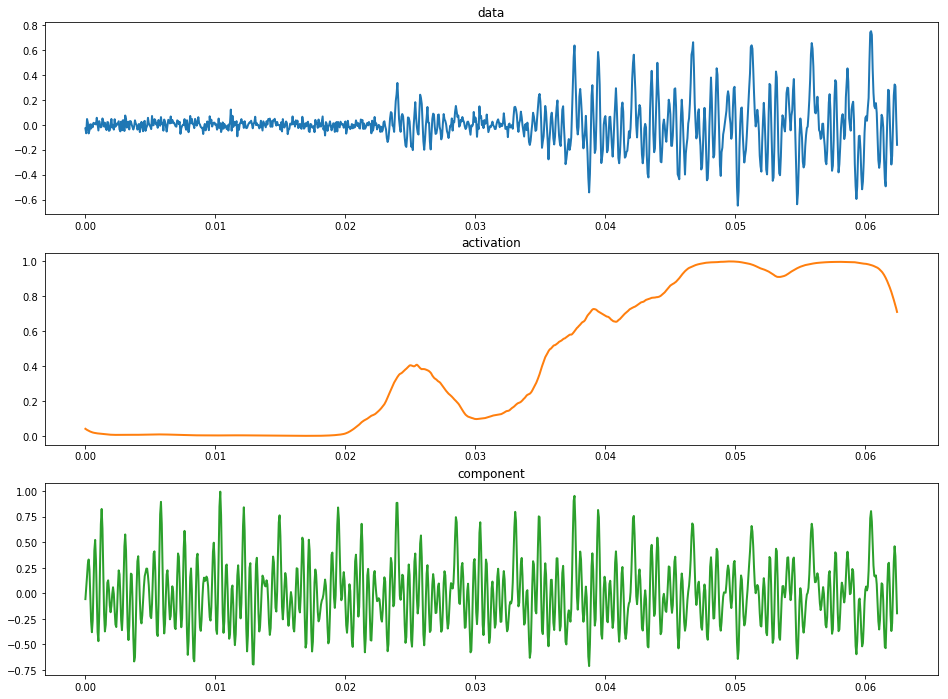

In [7]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y, 'C0', lw=2 )
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act, 'C1', lw=2)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com, 'C2', lw=2)

## Define model
We take advantage of the information available in the Fourier transform of the data to initialize the component hyper-parameters, i.e. the frequency of each harmonic and its variance.

(0, 8000)

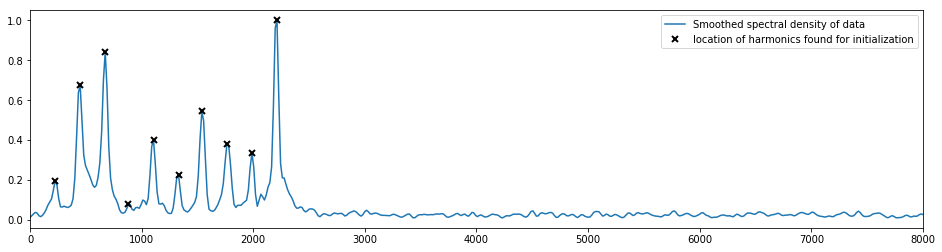

In [8]:
F_star, S_star, F, Y, S = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, ideal_f0=f0, scaled=True)  # get freqs and var 

plt.figure()
plt.plot(F, S/np.max(S))
plt.plot(F_star, S_star/np.max(S_star), 'xk', mew=2)
plt.legend(['Smoothed spectral density of data', 'location of harmonics found for initialization'])
plt.xlim([0, 8000])

Define kernels for component and activation, and generate model object ("sigmoid model")

In [9]:
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.05, variances=S_star, 
                                        frequencies=F_star, Nc=Nc)
kern_act = gpflow.kernels.Matern32(1)

In [10]:
dec = 160  # samples per window, decimation factor
z = np.vstack((x[::dec].copy(), x[-1].copy()))
m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act)  # sigmoid model
m.z.fixed = True
m.kern_com.fixed = True

Set all parameters free to optimize, but variances of component

## Inference
Run optimizer several times to get a better visualization of parameters convergence, take the mean of the parameters results and optimize again. Finally, optimize variances of component kernel, as well as variational parameters.

In [11]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1
m.x.minibatch_size = 100
m.x.minibatch_size = 100

In [12]:
m.optimize(method=tf.train.AdamOptimizer(), maxiter=1000, callback=logger)

     fun: 584.40943939695762
     jac: array([  1.89947683e+00,  -4.39856339e+00,   3.66340141e+02,
         1.62614110e+01,   1.19148493e+00,  -3.09446230e-03,
        -5.99056284e-03,  -1.80182281e-03,  -2.49320356e-04,
        -8.30889713e-06,   2.98912168e-08,   1.68829986e-02,
         6.79576237e-03,  -2.88386019e-01,   4.80682517e-06,
         1.67611673e-04,  -1.03114122e-02,  -5.27058223e-03,
         1.84565382e-02,   4.54114541e-01,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -9.15646797e-02,   2.23741862e-04,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -6.27438118e-04,
         4.93013068e-05,   4.66485059e-06,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -2.91509412e-04,   1.99888843e-05,
         4.23409487e-06,   3.14788490e-06,  -0

Text(0,0.5,u'ELBO')

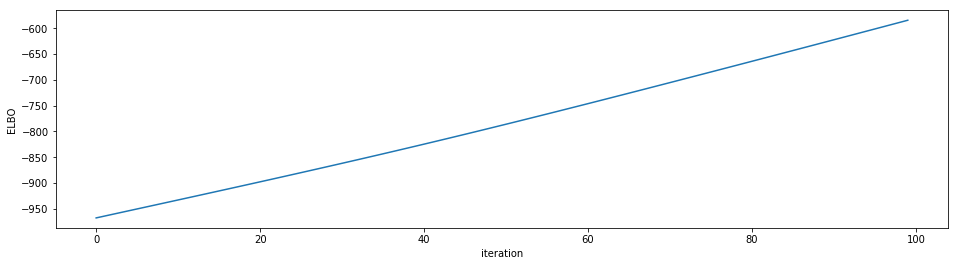

In [13]:
plt.plot(-np.array(logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

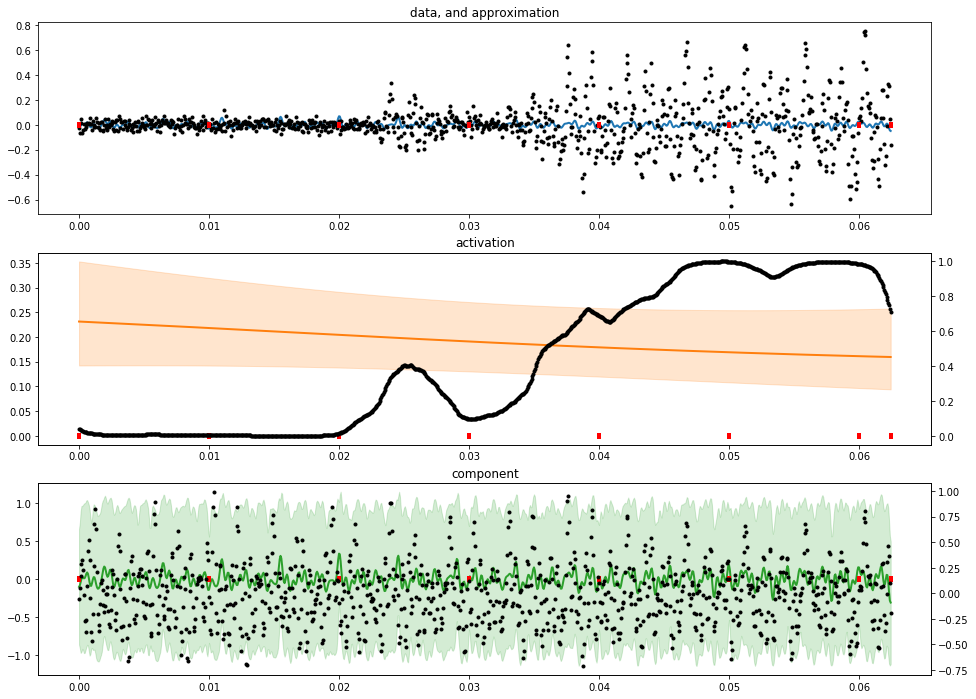

In [16]:
reload(myplots)
mean_f, var_f, mean_g, var_g, x_plot  = m.predict_all(x)
myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z)
plt.subplot(3, 1, 2)
plt.twinx()
plt.plot(x_plot, act, '.k')
plt.subplot(3, 1, 3)
plt.twinx()
plt.plot(x_plot, com, '.k')

List of learned hyperparameters

In [ ]:
#m.kern_act

In [ ]:
#print m.likelihood.variance

## Results
Compute prediction for component and activation, plot results

### Plot prediction

### Plot learned kernel

In [ ]:
x_eval = x.copy() 
k_plot_model = m.kern_com.compute_K(x_eval, np.asarray(0.).reshape(-1,1))
k_plot_sample = kern1.compute_K(x_eval, np.asarray(0.).reshape(-1,1))

plt.figure(figsize=(16, 4))
plt.plot(x_eval, k_plot_model, lw=2)


### Compare spectral density of data and learned component kernel

In [ ]:
N = x_eval.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(F, S / np.max(np.abs(S)), lw=2)
plt.legend([' Spectral density data'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 8000])

plt.subplot(2, 1, 2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
plt.legend([' Spectral density learned component kernel'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 8000])